In [10]:
import os
from urllib import urlretrieve
# In python 3, use 'from urllib.request import urlretrieve' instead
import gzip
import matplotlib.pyplot as plt
import numpy as np
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
if not os.path.isfile('yeast.fasta.gz'):
    print 'Downloading the FASTA file for Saccharomyces cerevisiae...'
    urlretrieve(
        'ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/'
        'knowledgebase/proteomes/YEAST.fasta.gz',
        'yeast.fasta.gz')
    print 'Done!'
    
    

Done!


In [3]:
print 'Cleaving the proteins with trypsin...'
unique_peptides = set()
for description, sequence in fasta.read(gzip.open('yeast.fasta.gz')):
    new_peptides = parser.cleave(sequence, parser.expasy_rules['trypsin'])
    unique_peptides.update(new_peptides)
print 'Done, {0} sequences obtained!'.format(len(unique_peptides))

Cleaving the proteins with trypsin...
Done, 193345 sequences obtained!


In [4]:
peptides = [{'sequence': i} for i in unique_peptides]

peptides

[{'sequence': 'MLTQK'},
 {'sequence': 'LFGWTAIFVAAAEGFTDIVK'},
 {'sequence': 'DILNEIDR'},
 {'sequence': 'DGDDLVYEAEIDLLTAIAGGEFALEHVSGDWLK'},
 {'sequence': 'SIETYLLTNK'},
 {'sequence': 'HIPASVLK'},
 {'sequence': 'LTDAEVDELLK'},
 {'sequence': 'ILVTAIK'},
 {'sequence': 'DDAENTK'},
 {'sequence': 'YAADSVER'},
 {'sequence': 'VYNTIVK'},
 {'sequence': 'ILELMESTVATSVIYESVNCIVK'},
 {'sequence': 'SMPQLNDGK'},
 {'sequence': 'DPSSVHVSWDAYFK'},
 {'sequence': 'LESEIENLK'},
 {'sequence': 'DVDLIESMK'},
 {'sequence': 'GMFNR'},
 {'sequence': 'GSQDDDESSLDSLNESVELLGNLGK'},
 {'sequence': 'LTLLTR'},
 {'sequence': 'FGYTCEQLFETMSALQK'},
 {'sequence': 'NGLTPITSLPNYNEDYK'},
 {'sequence': 'SNDSLTYNCGK'},
 {'sequence': 'VSSEETIPFLYELK'},
 {'sequence': 'WHFSHTFCSIGDYDPQDILK'},
 {'sequence': 'TALENFLR'},
 {'sequence': 'GTTEIER'},
 {'sequence': 'GNWMSFFSLCYSITATWGSITADYYILFPEDTPYIQIFCLTFFGTFLPTCFVGILGLLLASVAMSYKPWSVEYDSHGMGGLLWAGFQR'},
 {'sequence': 'AIVVQGPDGK'},
 {'sequence': 'QPFKPESSK'},
 {'sequence': 'SFISEVNAG

In [5]:
print 'Parsing peptide sequences...'
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(
        peptide['sequence'],
        show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
print 'Done!'

peptides = [peptide for peptide in peptides if peptide['length'] <= 100]

peptides

Parsing peptide sequences...
Done!


[{'length': 5,
  'parsed_sequence': ['H-', 'M', 'L', 'T', 'Q', 'K', '-OH'],
  'sequence': 'MLTQK'},
 {'length': 20,
  'parsed_sequence': ['H-',
   'L',
   'F',
   'G',
   'W',
   'T',
   'A',
   'I',
   'F',
   'V',
   'A',
   'A',
   'A',
   'E',
   'G',
   'F',
   'T',
   'D',
   'I',
   'V',
   'K',
   '-OH'],
  'sequence': 'LFGWTAIFVAAAEGFTDIVK'},
 {'length': 8,
  'parsed_sequence': ['H-', 'D', 'I', 'L', 'N', 'E', 'I', 'D', 'R', '-OH'],
  'sequence': 'DILNEIDR'},
 {'length': 33,
  'parsed_sequence': ['H-',
   'D',
   'G',
   'D',
   'D',
   'L',
   'V',
   'Y',
   'E',
   'A',
   'E',
   'I',
   'D',
   'L',
   'L',
   'T',
   'A',
   'I',
   'A',
   'G',
   'G',
   'E',
   'F',
   'A',
   'L',
   'E',
   'H',
   'V',
   'S',
   'G',
   'D',
   'W',
   'L',
   'K',
   '-OH'],
  'sequence': 'DGDDLVYEAEIDLLTAIAGGEFALEHVSGDWLK'},
 {'length': 10,
  'parsed_sequence': ['H-',
   'S',
   'I',
   'E',
   'T',
   'Y',
   'L',
   'L',
   'T',
   'N',
   'K',
   '-OH'],
  'sequence': 'SIETYLL

In [6]:
print 'Calculating the mass, charge and m/z...'
for peptide in peptides:
    peptide['charge'] = int(round(
        electrochem.charge(peptide['parsed_sequence'], pH=2.0)))
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z'] = mass.calculate_mass(peptide['parsed_sequence'], 
        charge=peptide['charge'])
print 'Done!'


Calculating the mass, charge and m/z...
Done!


In [8]:
print 'Calculating the retention time...'
for peptide in peptides:
    peptide['RT_RP'] = achrom.calculate_RT(
        peptide['parsed_sequence'],
        achrom.RCs_zubarev)
    peptide['RT_normal'] = achrom.calculate_RT(
        peptide['parsed_sequence'],
        achrom.RCs_yoshida_lc)
print 'Done!'

Calculating the retention time...
Done!


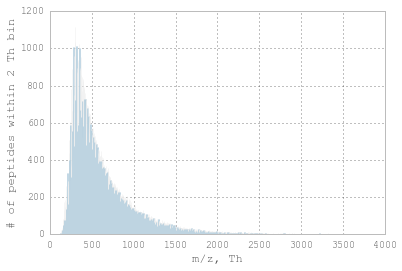

In [11]:
plt.figure()
plt.hist([peptide['m/z'] for peptide in peptides], 
    bins = 2000,
    range=(0,4000))
plt.xlabel('m/z, Th')
plt.ylabel('# of peptides within 2 Th bin')

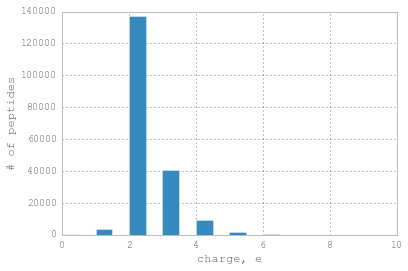

In [12]:
plt.figure()
plt.hist([peptide['charge'] for peptide in peptides],
    bins = 20,
    range=(0,10))
plt.xlabel('charge, e')
plt.ylabel('# of peptides')

In [13]:
x = [peptide['RT_RP'] for peptide in peptides]
y = [peptide['RT_normal'] for peptide in peptides]
heatmap, xbins, ybins = np.histogram2d(x, y, bins=100)
heatmap[heatmap == 0] = np.nan
a, b, r, stderr = auxiliary.linear_regression(x,y)

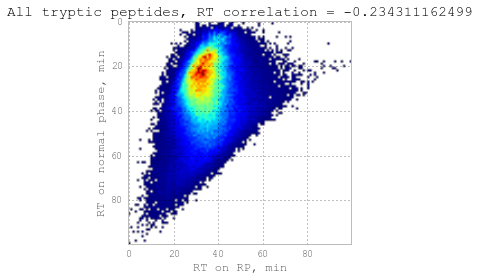

In [14]:
plt.figure()
plt.imshow(heatmap)
plt.xlabel('RT on RP, min')
plt.ylabel('RT on normal phase, min')
plt.title('All tryptic peptides, RT correlation = {0}'.format(r))

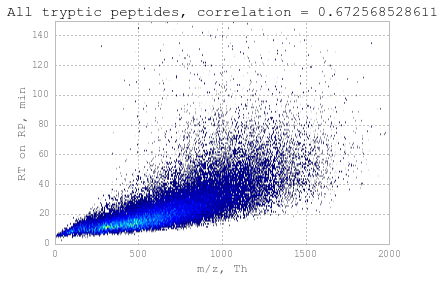

In [15]:
x = [peptide['m/z'] for peptide in peptides]
y = [peptide['RT_RP'] for peptide in peptides]
heatmap, xbins, ybins = np.histogram2d(x, y, 
    bins=[150, 2000],
    range=[[0, 4000], [0, 150]])
heatmap[heatmap == 0] = np.nan
a, b, r, stderr = auxiliary.linear_regression(x,y)

plt.figure()
plt.imshow(heatmap, 
    aspect='auto',
    origin='lower')
plt.xlabel('m/z, Th')
plt.ylabel('RT on RP, min')
plt.title('All tryptic peptides, correlation = {0}'.format(r))

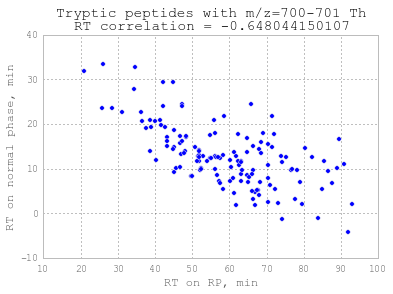

In [16]:
close_mass_peptides = [peptide for peptide in peptides 
                       if 700.0 <= peptide['m/z'] <= 701.0]
x = [peptide['RT_RP'] for peptide in close_mass_peptides]
y = [peptide['RT_normal'] for peptide in close_mass_peptides]
a, b, r, stderr = auxiliary.linear_regression(x, y)

plt.figure()
plt.scatter(x, y)
plt.xlabel('RT on RP, min')
plt.ylabel('RT on normal phase, min')
plt.title('Tryptic peptides with m/z=700-701 Th\nRT correlation = {0}'.format(r))

plt.show()

In [17]:
from pandas import DataFrame, Series
import pandas as pd

In [19]:
DataFrame.from_dict(peptides)

,RT_RP,RT_normal,charge,length,m/z,mass,parsed_sequence,sequence
0,29.731616,8.178036,2,5,310.675443,619.336333,"[H-, M, L, T, Q, K, -OH]",MLTQK
1,94.088572,0.641366,2,20,1078.574965,2155.135378,"[H-, L, F, G, W, T, A, I, F, V, A, A, A, E, G,...",LFGWTAIFVAAAEGFTDIVK
2,46.350227,9.742983,2,8,494.258914,986.503274,"[H-, D, I, L, N, E, I, D, R, -OH]",DILNEIDR
3,92.582711,10.319972,3,33,1187.913901,3560.719875,"[H-, D, G, D, D, L, V, Y, E, A, E, I, D, L, L,...",DGDDLVYEAEIDLLTAIAGGEFALEHVSGDWLK
4,50.925887,10.476759,2,10,591.324253,1180.633954,"[H-, S, I, E, T, Y, L, L, T, N, K, -OH]",SIETYLLTNK
5,38.706012,7.716115,3,8,288.848239,863.522887,"[H-, H, I, P, A, S, V, L, K, -OH]",HIPASVLK
6,56.593194,7.468041,2,11,623.332275,1244.649998,"[H-, L, T, D, A, E, V, D, E, L, L, K, -OH]",LTDAEVDELLK
7,50.541220,0.201570,2,7,379.262739,756.510926,"[H-, I, L, V, T, A, I, K, -OH]",ILVTAIK
8,16.289714,18.880383,2,7,396.672140,791.329727,"[H-, D, D, A, E, N, T, K, -OH]",DDAENTK
9,29.856297,11.717281,2,8,455.716882,909.419210,"[H-, Y, A, A, D, S, V, E, R, -OH]",YAADSVER


#Source Code for Parser#
http://pythonhosted.org/pyteomics/_modules/pyteomics/parser.html#cleave

##Expasy Rules##

In [20]:
expasy_rules = {
    'arg-c':         r'R',
    'asp-n':         r'\w(?=D)',
    'bnps-skatole' : r'W',
    'caspase 1':     r'(?<=[FWYL]\w[HAT])D(?=[^PEDQKR])',
    'caspase 2':     r'(?<=DVA)D(?=[^PEDQKR])',
    'caspase 3':     r'(?<=DMQ)D(?=[^PEDQKR])',
    'caspase 4':     r'(?<=LEV)D(?=[^PEDQKR])',
    'caspase 5':     r'(?<=[LW]EH)D',
    'caspase 6':     r'(?<=VE[HI])D(?=[^PEDQKR])',
    'caspase 7':     r'(?<=DEV)D(?=[^PEDQKR])',
    'caspase 8':     r'(?<=[IL]ET)D(?=[^PEDQKR])',
    'caspase 9':     r'(?<=LEH)D',
    'caspase 10':    r'(?<=IEA)D',
    'chymotrypsin high specificity' : r'([FY](?=[^P]))|(W(?=[^MP]))',
    'chymotrypsin low specificity':
        r'([FLY](?=[^P]))|(W(?=[^MP]))|(M(?=[^PY]))|(H(?=[^DMPW]))',
    'clostripain':   r'R',
    'cnbr':          r'M',
    'enterokinase':  r'(?<=[DE]{3})K',
    'factor xa':     r'(?<=[AFGILTVM][DE]G)R',
    'formic acid':   r'D',
    'glutamyl endopeptidase': r'E',
    'granzyme b':    r'(?<=IEP)D',
    'hydroxylamine': r'N(?=G)',
    'iodosobenzoic acid': r'W',
    'lysc':          r'K',
    'ntcb':          r'\w(?=C)',
    'pepsin ph1.3':  r'((?<=[^HKR][^P])[^R](?=[FLWY][^P]))|'
                     r'((?<=[^HKR][^P])[FLWY](?=\w[^P]))',
    'pepsin ph2.0':  r'((?<=[^HKR][^P])[^R](?=[FL][^P]))|'
                     r'((?<=[^HKR][^P])[FL](?=\w[^P]))',
    'proline endopeptidase': r'(?<=[HKR])P(?=[^P])',
    'proteinase k':  r'[AEFILTVWY]',
    'staphylococcal peptidase i': r'(?<=[^E])E',
    'thermolysin':   r'[^DE](?=[AFILMV])',
    'thrombin':      r'((?<=G)R(?=G))|'
                     r'((?<=[AFGILTVM][AFGILTVWA]P)R(?=[^DE][^DE]))',
    'trypsin':       r'([KR](?=[^P]))|((?<=W)K(?=P))|((?<=M)R(?=P))'
    }